In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import gc

In [2]:
y_train = pd.read_csv('data/train_label.csv', index_col=0)
# train_preprocessed.csv', index_col=0)['label']
y_train.head()

,label
id,
0,110
1,29
2,111
3,176
4,130


## Check the imbalance of data

In [3]:
y_train_count = y_train.label.value_counts().sort_values()

print('number of labels :', len(y_train))
print(f'number of labels with only one file :', len(y_train_count[y_train_count==1]))
print('\nNumber of files for each label :\n', y_train_count, sep='')

number of labels : 827
number of labels with only one file : 87

Number of files for each label :
98      1
48      1
36      1
50      1
49      1
       ..
113    19
118    20
114    20
17     21
110    24
Name: label, Length: 198, dtype: int64


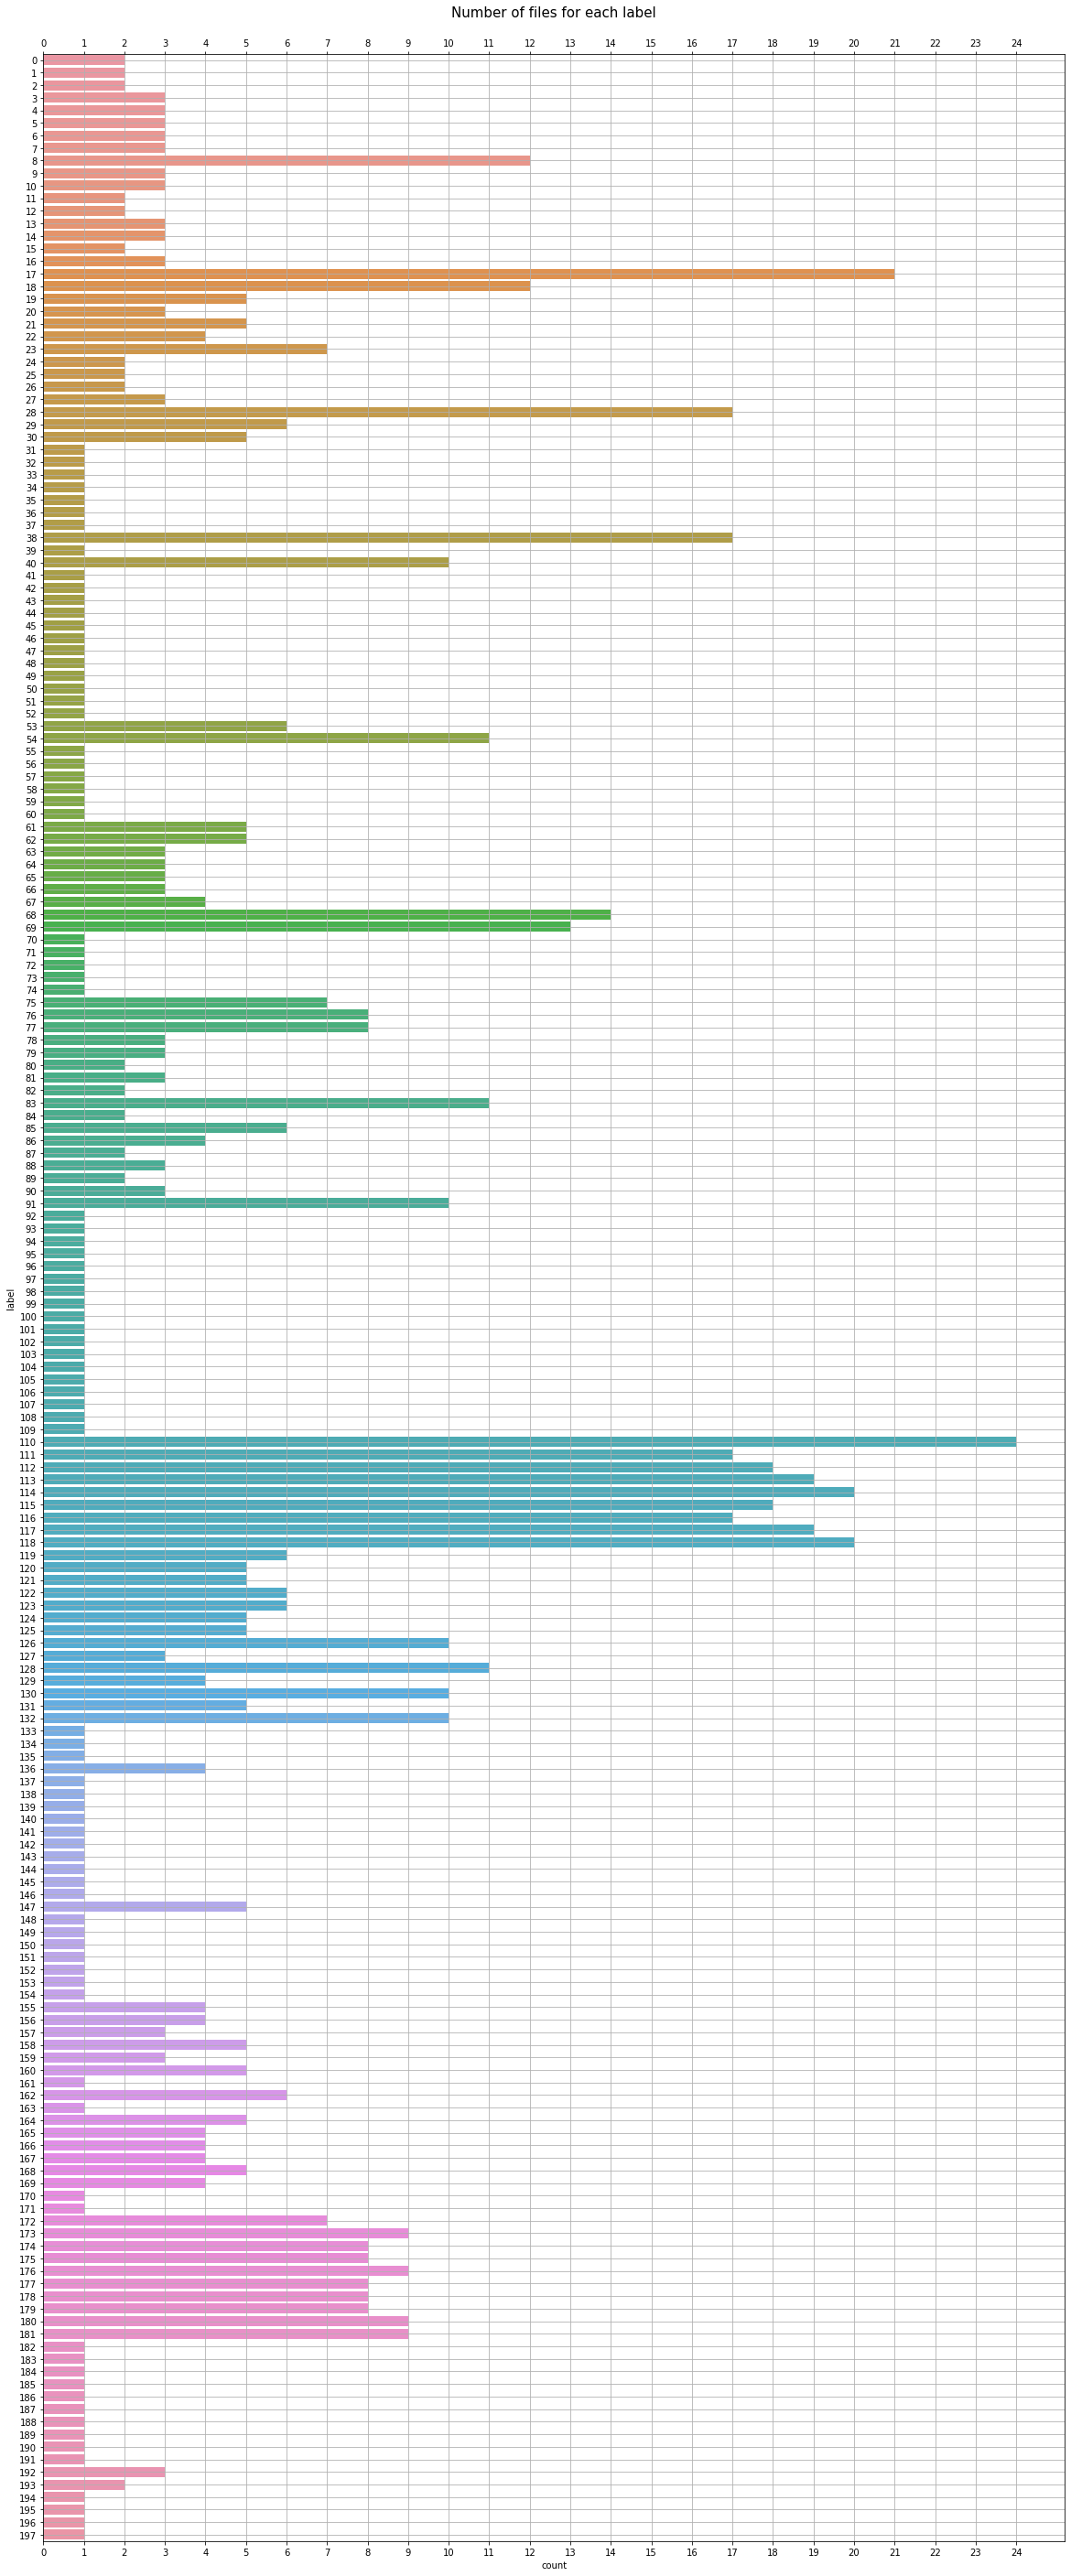

In [4]:
plt.figure(figsize=(20, 50))
sns.countplot(y=y_train.label)

plt.title('Number of files for each label\n', size=15)
plt.tick_params(labeltop=True, top=True, labelsize=10)
plt.xticks(range(25))
plt.grid()

plt.show()

## Generate balanced file list

if we get 50 records for each file in whole dataset, the total will be 41,350 rows (827 * 50) and it will be seriously imbalanced
On the other hand, if we get 150 records for each file in balanced dataset, the total will be just 29,700 rows (198 * 150) without imbalance problem

In [5]:
balanced_idx_list = list(y_train.drop_duplicates().index)
train_list = [f'{idx}.csv' for idx in balanced_idx_list]
print(train_list)

['0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv', '10.csv', '12.csv', '13.csv', '15.csv', '17.csv', '18.csv', '19.csv', '20.csv', '21.csv', '23.csv', '25.csv', '26.csv', '27.csv', '29.csv', '31.csv', '32.csv', '33.csv', '34.csv', '35.csv', '36.csv', '38.csv', '41.csv', '43.csv', '44.csv', '45.csv', '46.csv', '48.csv', '50.csv', '51.csv', '56.csv', '57.csv', '58.csv', '63.csv', '64.csv', '65.csv', '66.csv', '68.csv', '72.csv', '73.csv', '75.csv', '76.csv', '78.csv', '79.csv', '81.csv', '86.csv', '88.csv', '89.csv', '91.csv', '93.csv', '94.csv', '95.csv', '97.csv', '99.csv', '101.csv', '103.csv', '106.csv', '108.csv', '110.csv', '112.csv', '115.csv', '116.csv', '117.csv', '120.csv', '121.csv', '123.csv', '124.csv', '126.csv', '130.csv', '134.csv', '135.csv', '138.csv', '141.csv', '145.csv', '148.csv', '149.csv', '152.csv', '159.csv', '167.csv', '173.csv', '174.csv', '175.csv', '176.csv', '178.csv', '182.csv', '184.csv', '185.csv', '186.csv', '187.

## But what if, There are significant variances between files with same label?
To check that hypothesis, We need to take a closer look at files with same label. (such as label 110, which has largest number of files) <br>
We could perform Anova test of certain variables between files with same label. <br>
To decide which variables to be tested, we can use the feature importances from Random Forest

In [6]:
label_110_idx = y_train[y_train.label==110].index
label_110_files = [f'{idx}.csv' for idx in label_110_idx]

print(len(label_110_files), 'files have label "110"')
print(label_110_files)

24 files have label "110"
['0.csv', '22.csv', '59.csv', '122.csv', '170.csv', '198.csv', '213.csv', '224.csv', '245.csv', '299.csv', '312.csv', '379.csv', '419.csv', '432.csv', '491.csv', '534.csv', '562.csv', '609.csv', '702.csv', '724.csv', '731.csv', '751.csv', '758.csv', '827.csv']


In [7]:
# Use feature importances
ftr_importances_df = pd.read_csv('train_feature_importances.csv', index_col=0)
ftr_importances_df.columns = ['ftr_importance']
ftr_importances_df.sort_values('ftr_importance', ascending=False).head(10)

,ftr_importance
V2212,0.009842
V2208,0.009131
V2213,0.008624
V2215,0.008470
V2586,0.007850
V2587,0.007525
V2216,0.007508
V2079,0.007224
V2211,0.007189
V2185,0.007071


In [8]:
def get_column(file_list=[], col_name='', dir_path='data/train/'):
    tmp_list = []
    for file in file_list:
        tmp_df = pd.read_csv(dir_path + file, usecols=[col_name])
        tmp_df.columns = [f'{col_name}_{file.split(".")[0]}']
        tmp_list.append(tmp_df)
        pass
    
    return pd.concat(tmp_list, 1)

df1 = get_column(label_110_files, 'V2212')

In [9]:
df1.describe().loc[['mean', 'std', 'min', 'max']]

,V2212_0,V2212_22,V2212_59,V2212_122,V2212_170,V2212_198,V2212_213,V2212_224,V2212_245,V2212_299,...,V2212_491,V2212_534,V2212_562,V2212_609,V2212_702,V2212_724,V2212_731,V2212_751,V2212_758,V2212_827
mean,24.577905,24.594634,24.541541,24.560957,24.528945,24.520285,24.596574,24.575477,24.591647,24.557097,...,24.599439,24.538100,24.503888,24.545846,24.524189,24.533590,24.572957,24.554096,24.550013,24.588576
std,0.091505,0.095175,0.083399,0.087874,0.081778,0.080319,0.095562,0.091377,0.094633,0.087470,...,0.096179,0.084506,0.075453,0.085022,0.079967,0.083114,0.091768,0.087687,0.086361,0.094619
min,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,...,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100,24.152100
max,24.784800,24.819700,24.704000,24.747300,24.698500,24.680200,24.822900,24.786300,24.822200,24.756000,...,24.828800,24.719100,24.642600,24.727600,24.681500,24.707800,24.793500,24.754400,24.741100,24.818500


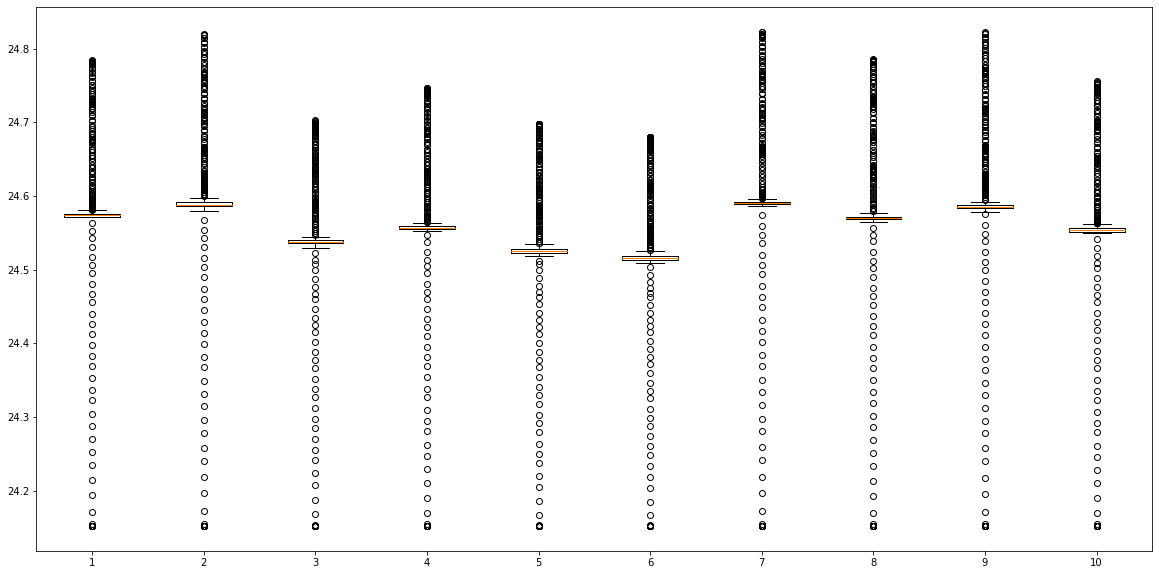

In [10]:
var_list = [list(df1[col]) for col in df1.columns]

plt.figure(figsize=(20, 10))
plt.boxplot(var_list[:10])
plt.show()

In [12]:
from scipy import stats
stats.kruskal(var_list[5], var_list[6])

KruskalResult(statistic=440.133341345794, pvalue=1.0125722286967093e-97)